# TCR repertoire analysis using Scirpy pipeline
Notebook adapted from tutorial https://scverse.org/scirpy/latest/tutorials/tutorial_3k_tcr.html

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
import sctk as sk
import seaborn as sb
import scrublet as scr
import matplotlib
from matplotlib import pyplot as plt, cm as mpl_cm
from glob import glob
import tarfile
import anndata
import warnings
from cycler import cycler

from matplotlib.pyplot import rc_context

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, color_map='OrRd')
sc.logging.print_header()


scanpy==1.8.2 anndata==0.8.0 umap==0.5.3 numpy==1.21.1 scipy==1.7.0 pandas==1.5.3 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [2]:
path='/nfs/team205/rb29/mice_gutTCRtg_project/Src/Mice-gut.TCRtg/new_analysis'

In [3]:
adata_TC=sc.read(path+"/h5ad_files/adata_TCs_only_newLabels.h5ad")

In [4]:
adata_new=ir.io.upgrade_schema(adata_TC)

In [5]:
ir.tl.chain_qc(adata_TC)

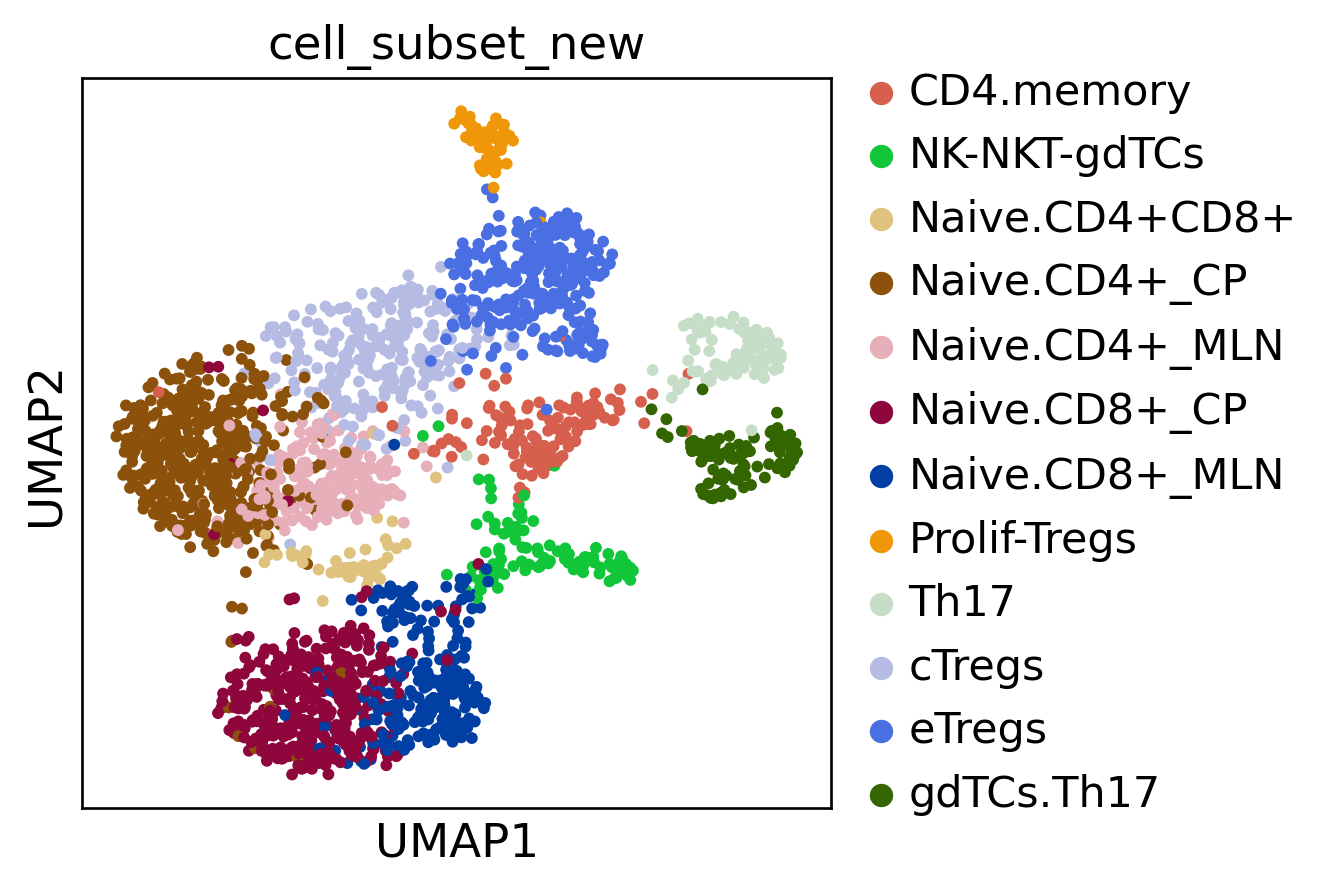

In [6]:
sc.pl.umap(adata_TC, color=['cell_subset_new'],ncols=2, wspace=0.9)

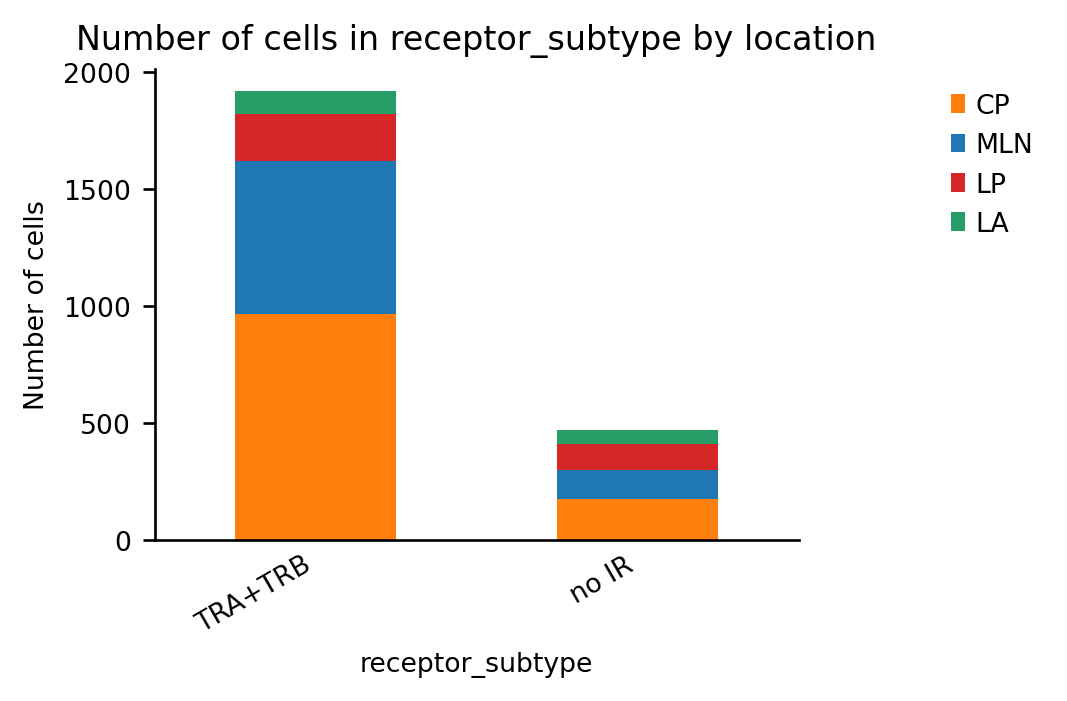

In [7]:
ax=ir.pl.group_abundance(adata_TC, groupby="receptor_subtype", target_col="location")

In [8]:
adata_TC.obs['chain_pairing'].value_counts()

single pair        1250
no IR               471
orphan VDJ          394
extra VJ            124
orphan VJ           113
extra VDJ            34
two full chains       3
Name: chain_pairing, dtype: int64

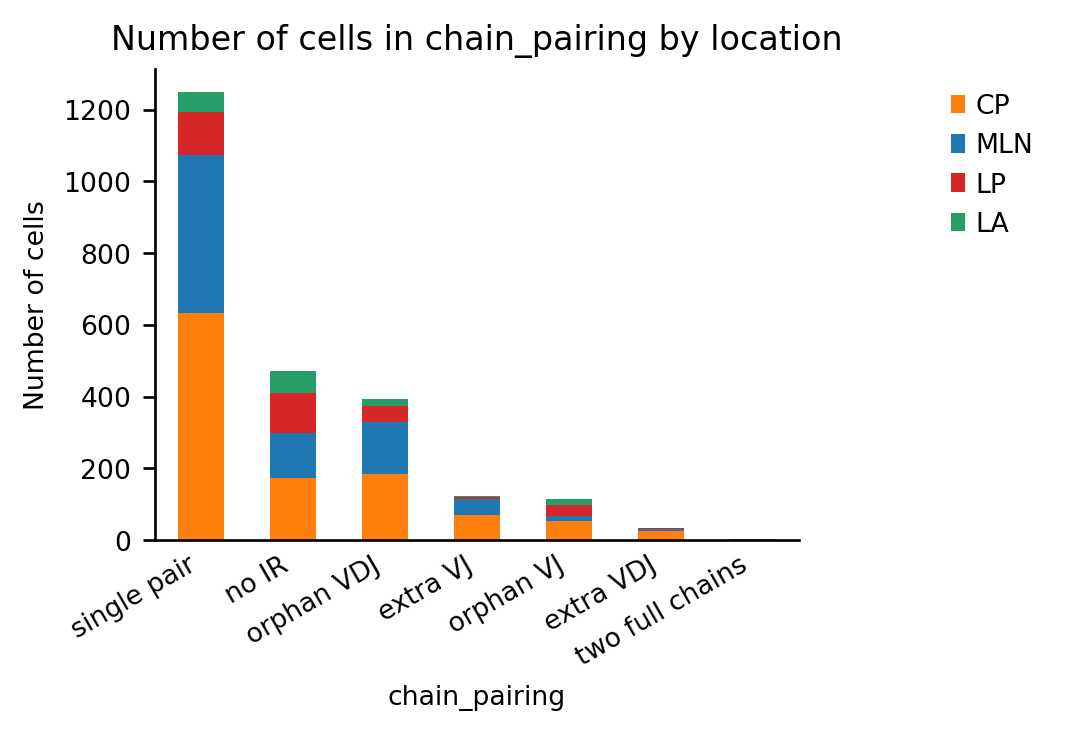

In [9]:
ax = ir.pl.group_abundance(adata_TC, groupby="chain_pairing", target_col="location")

chain pairing

Orphan chain refers to cells that have either a single alpha or beta receptor chain.

Extra chain refers to cells that have a full alpha/beta receptor pair, and an additional chain.

**Two full chains** refers to cells with more than two receptor pairs detected. These cells are likely doublets.

In [10]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(
            adata_TC.obs["chain_pairing"].isin(
                ["extra VJ", "extra VDJ", "two full chains"]
            )
        )
        / adata_TC.n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.07


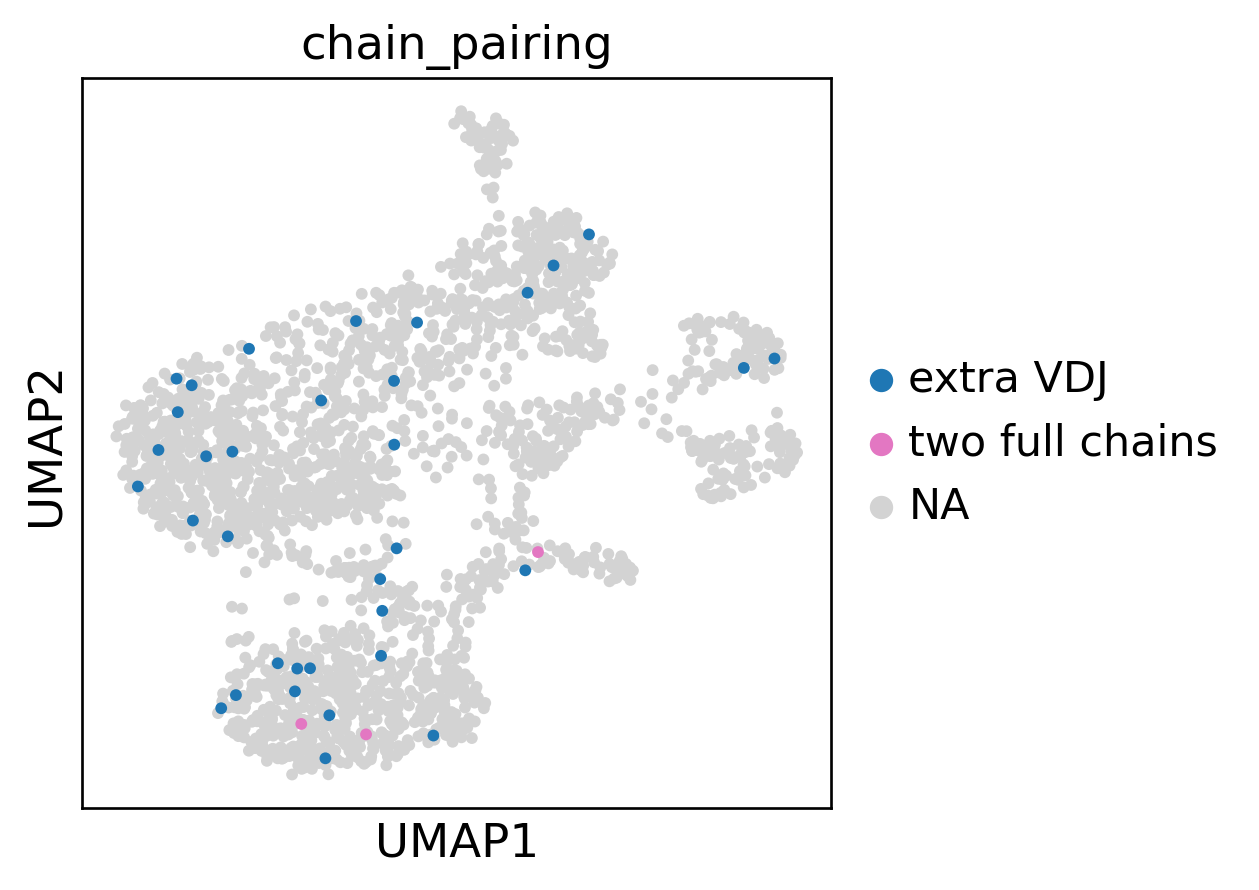

In [11]:
sc.pl.umap(adata_TC, color="chain_pairing", groups=["two full chains",'extra VDJ'])

Visualize the Multichain-cells on the UMAP plot and exclude them from downstream analysis:

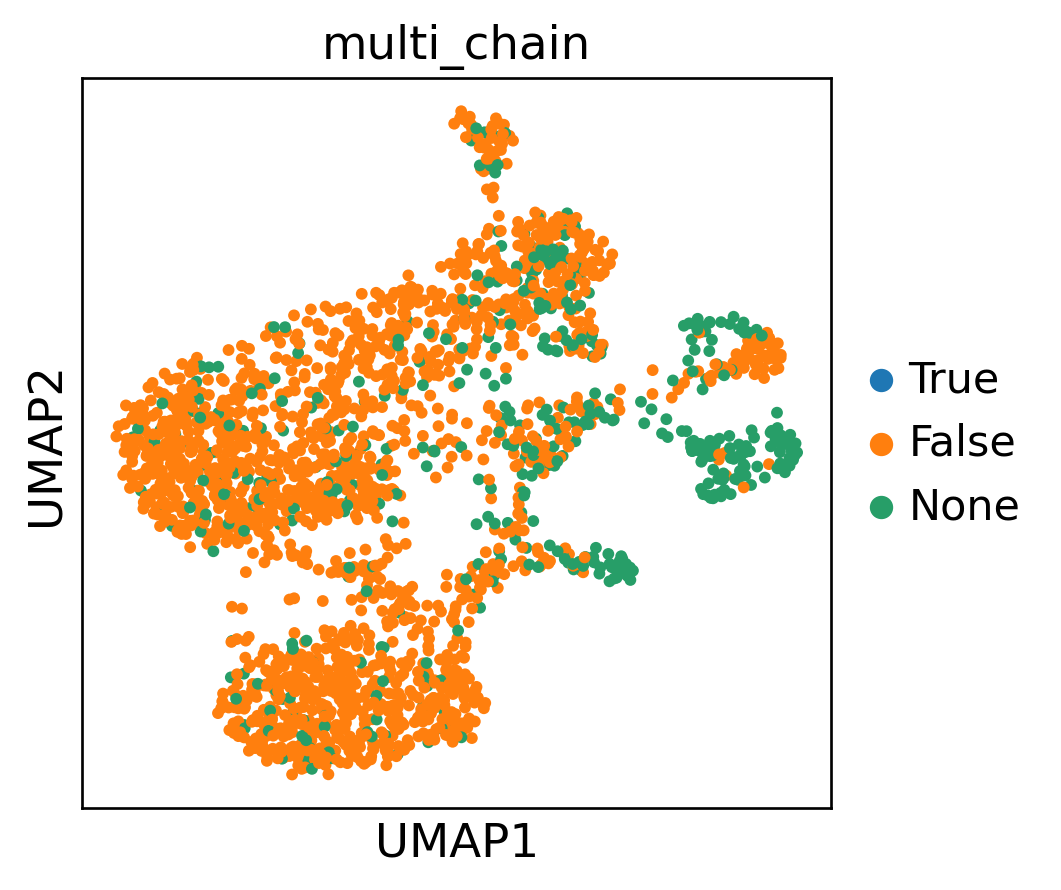

In [12]:
## From old version
sc.pl.umap(adata_TC, color="multi_chain")

In [13]:
adata_TC.obs['multi_chain'].value_counts()

False    1918
None      471
True        0
Name: multi_chain, dtype: int64

In [14]:
adata_TC.obs['chain_pairing'].value_counts()

single pair        1250
no IR               471
orphan VDJ          394
extra VJ            124
orphan VJ           113
extra VDJ            34
two full chains       3
Name: chain_pairing, dtype: int64

In [15]:
#Filter out cells with "two full chains", orphan alpha, extra beta (VDJ) or no IR data: allow orphan beta and extra alpha
adata = adata_TC[~adata_TC.obs["chain_pairing"].isin(['two full chains','no IR']), :].copy()

## Define clonotypes

#Compute CDR3 neighborhood graph and define clonotypes

In [16]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(adata,metric="identity", #default
             sequence="nt")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


In [17]:
ir.tl.define_clonotypes(adata, receptor_arms="any",#any = either VJ or VDJ need to match
                  dual_ir="any", same_v_gene=True) 

Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:00)
Computing clonotype x clonotype distances.


  0%|          | 0/1883 [00:00<?, ?it/s]

--> Done computing clonotype x clonotype distances.  (0:00:08)
Stored clonal assignments in `adata.obs["clone_id"]`.


#To visualize the network

In [18]:
ir.tl.clonotype_network(adata, min_cells=2) # Filter out clonotypes with less than 2 cells

<AxesSubplot:>

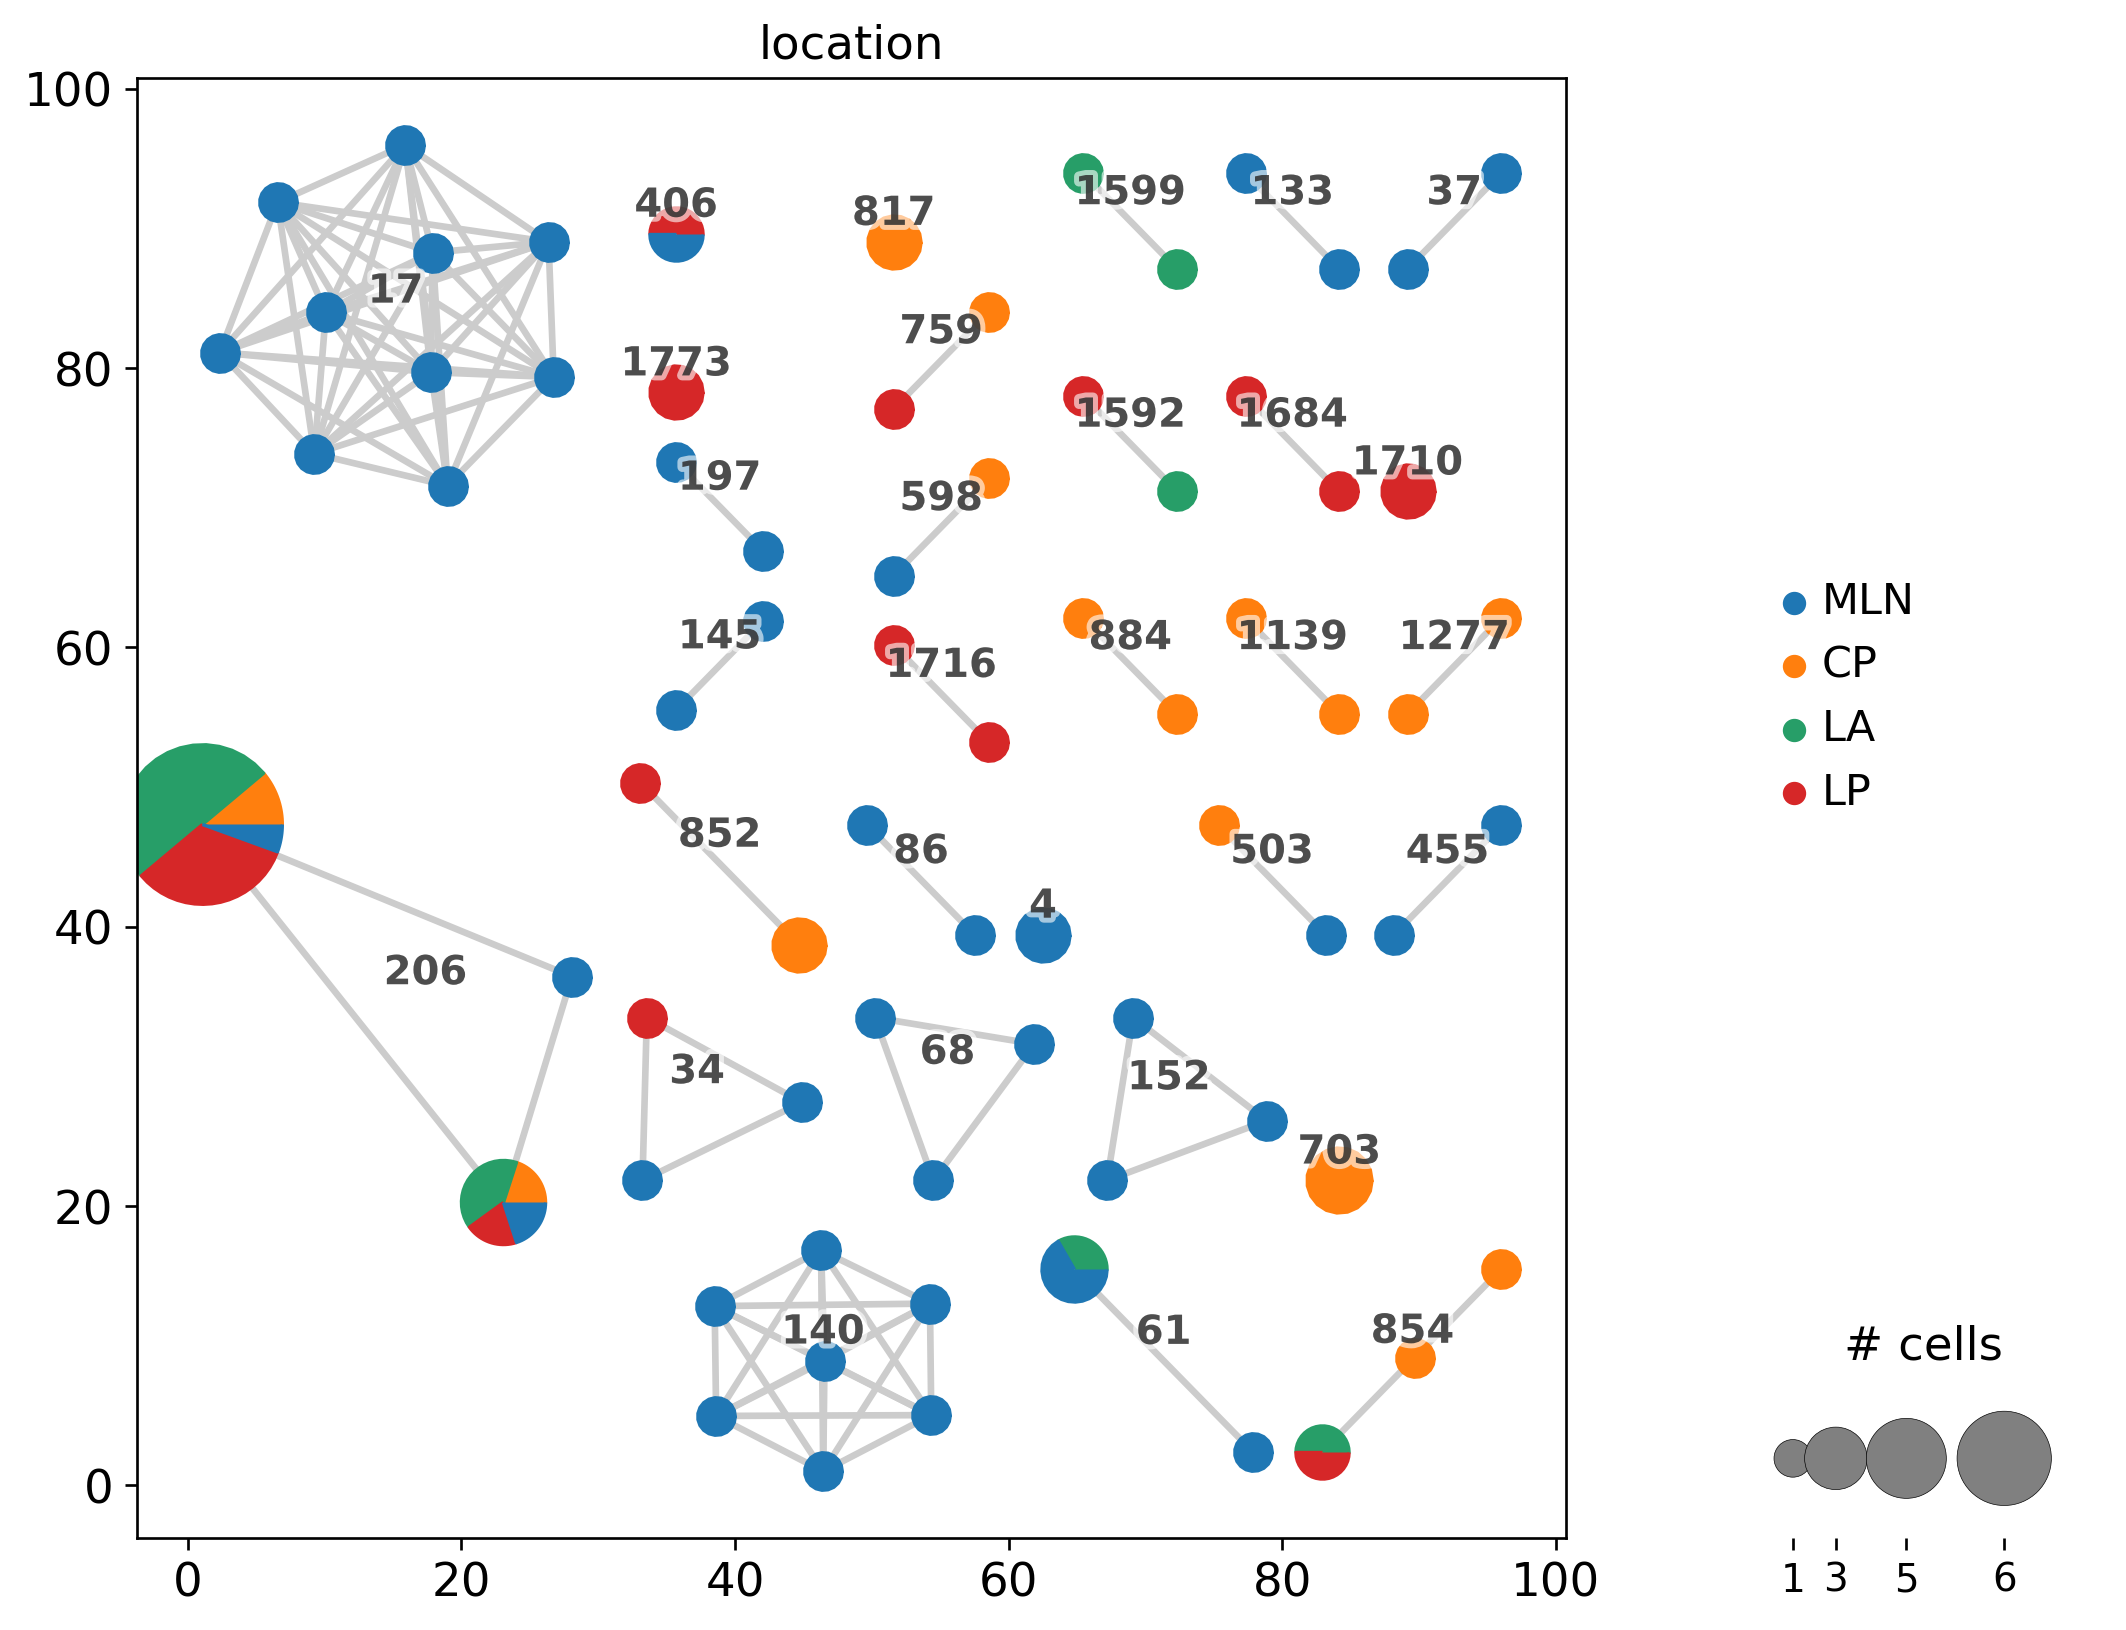

In [19]:
ir.pl.clonotype_network(adata, color="location", label_fontsize=12, panel_size=(8,8), edges_width=2)
#plt.savefig('/nfs/team205/rb29/mice_gutTCRtg_project/Src/Mice-gut.TCRtg/new_analysis/figures/newTCRclonotypes_aa_location.pdf', format='pdf')

<AxesSubplot:>

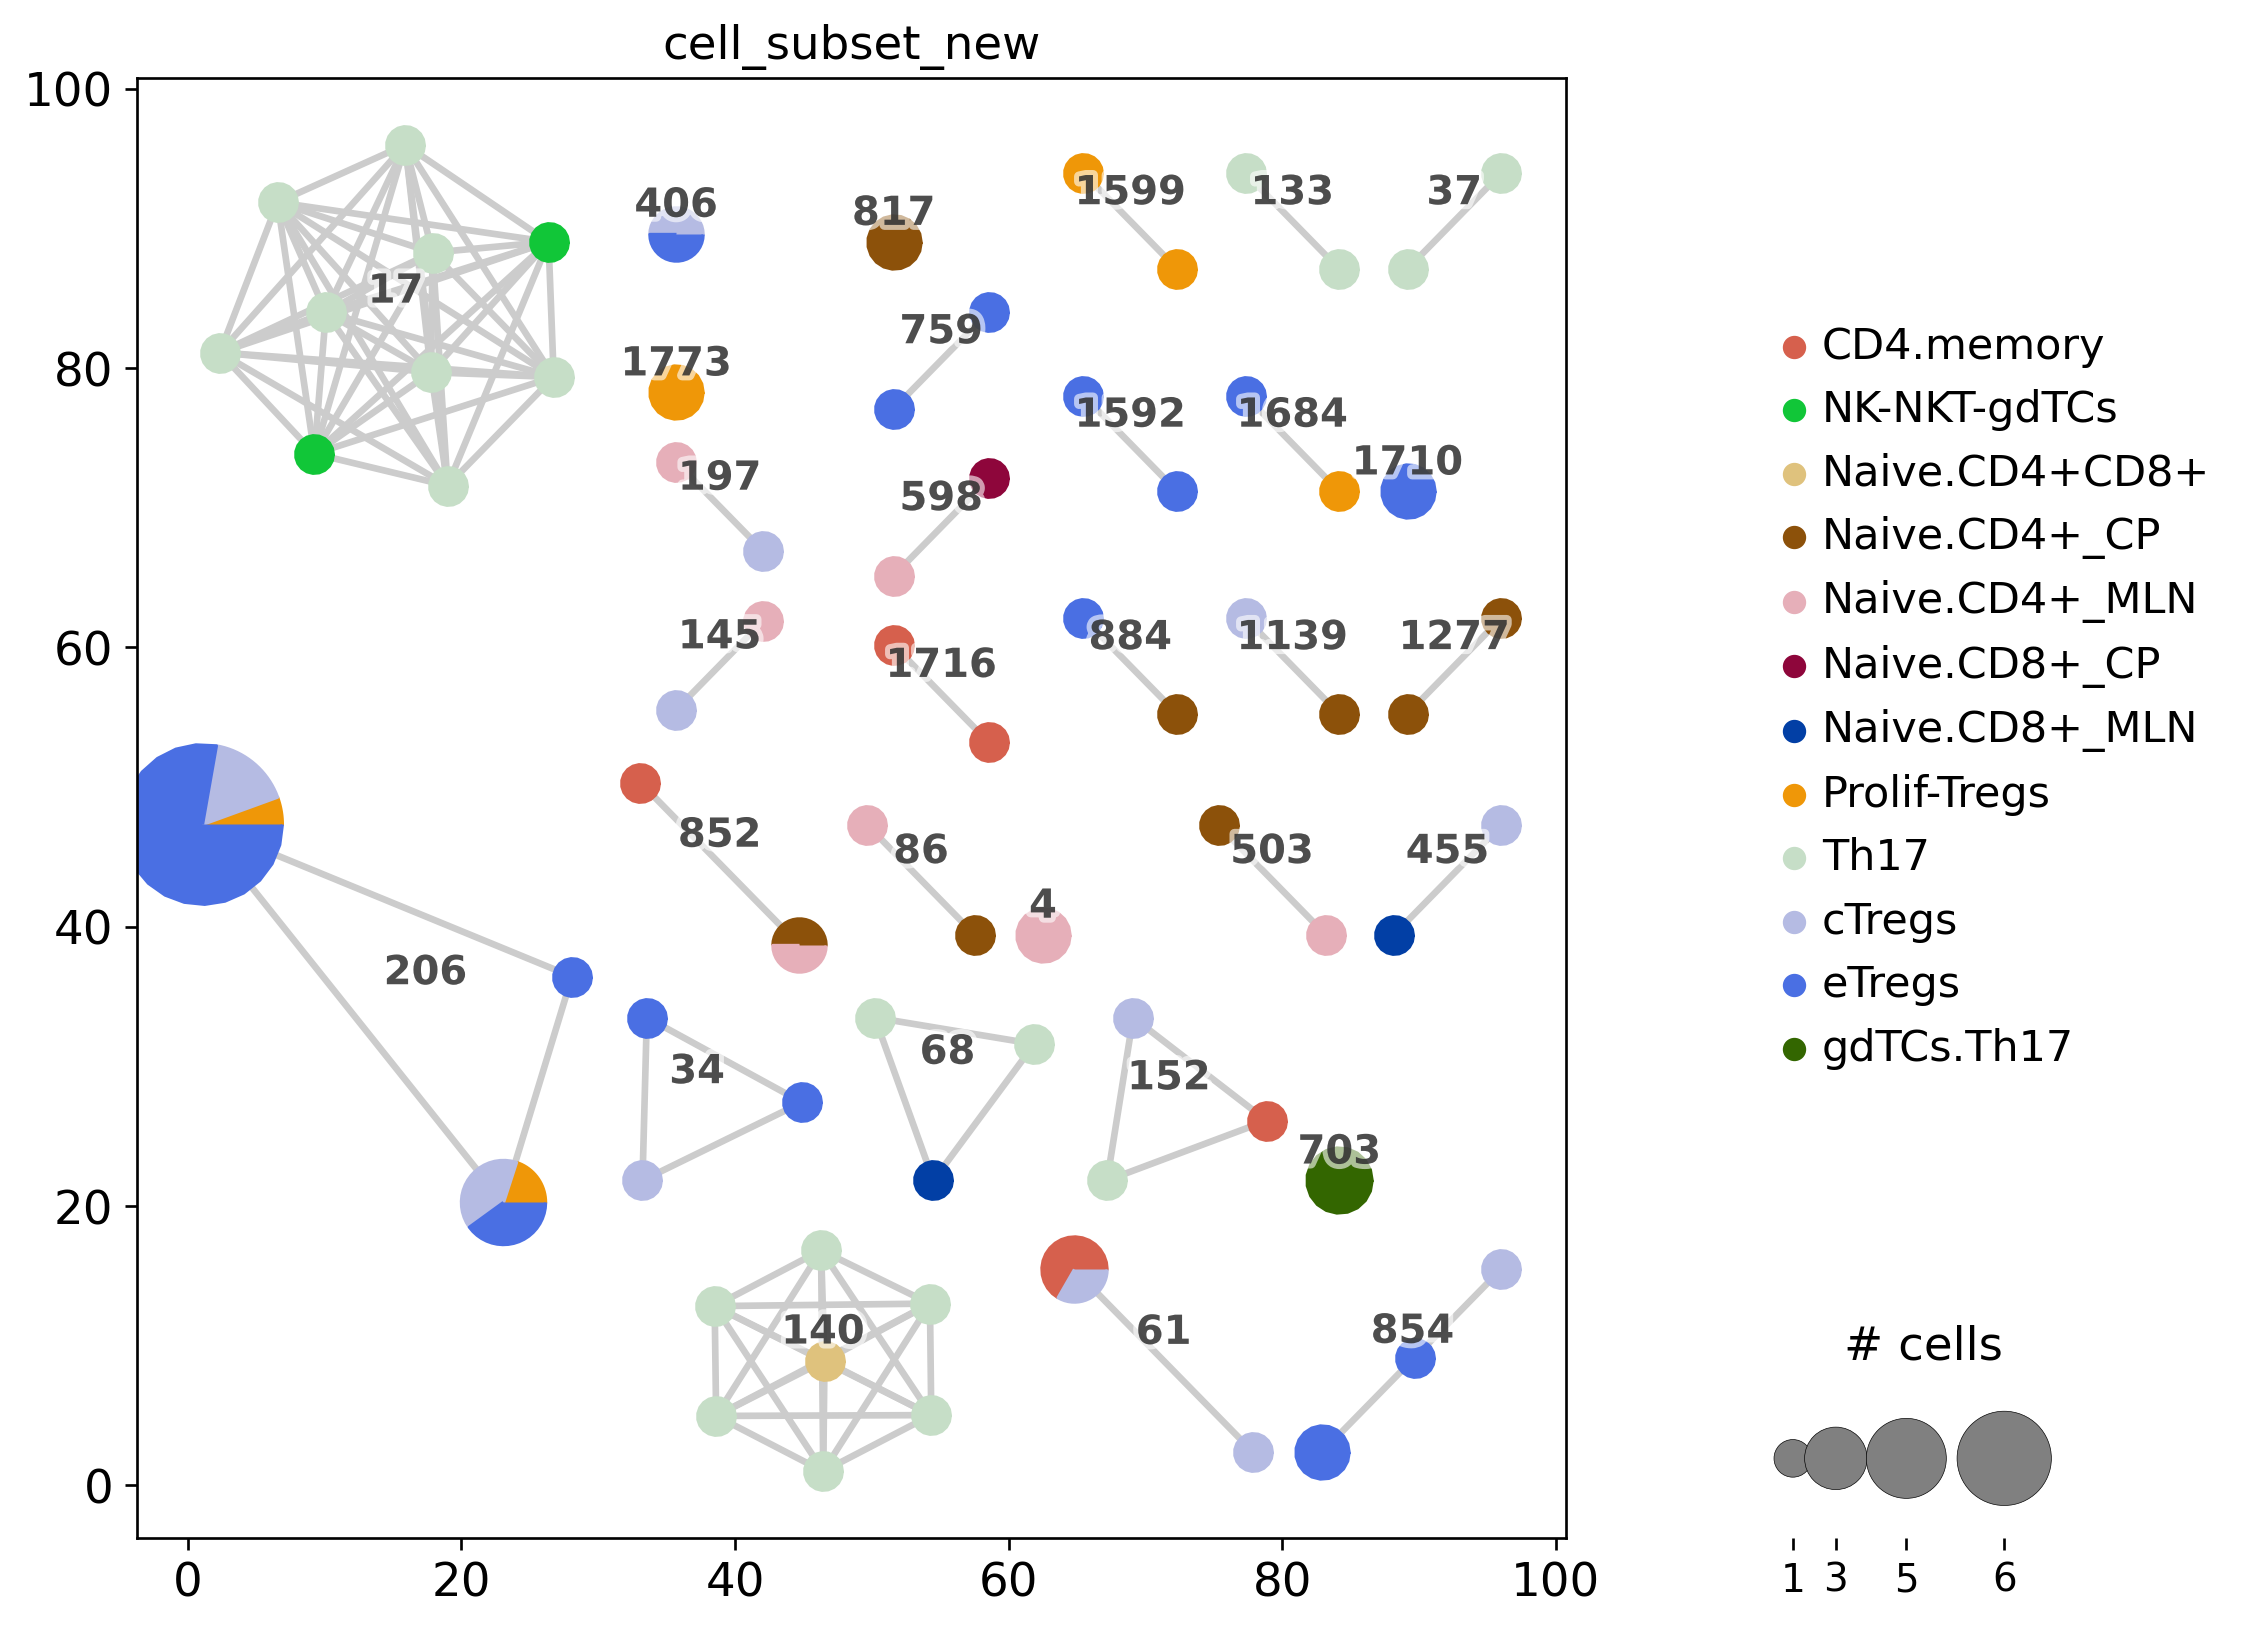

In [20]:
ir.pl.clonotype_network(adata, color="cell_subset_new", label_fontsize=12, panel_size=(8,8), edges_width=2)
#plt.savefig('/nfs/team205/rb29/mice_gutTCRtg_project/Src/Mice-gut.TCRtg/new_analysis/figures/newTCRclonotypes_aa_location.pdf', format='pdf')

# Transgenic TCR: 

Information about the Hh-specific TCRs was obtain from Xu et al. doi:10.1038/nature25500, Extended data figure 1C.
and the TCR sequences were retreived from https://www.ncbi.nlm.nih.gov/nuccore/ and mapped with V-Quest (https://www.imgt.org/IMGT_vquest/input)

In [21]:
HhTCRs=pd.read_csv('/nfs/team205/rb29/mice_gutTCRtg_project/Src/Mice-gut.TCRtg/new_analysis/Hh_specific_TCR.csv',index_col=0, sep=";")

In [22]:
HhTCRs

,V_GENE_TRA,V_GENE_TRA.1,J_GENE_TRA,AA_JUNCTION_TRA,V_GENE_TRB,J_GENE_TRB,D_GENE_TRB,AA_JUNCTION_TRB
Mus_musculus_clone,,,,,,,,
HH5-1,TRAV8-1,TRAV8-1,TRAJ27,CATDDTNTGKLTF,TRBV13-2,TRBJ2-5,TRBD1,CASGGTGGNQDTQYF
HH5-3,TRAV14-2,TRAV14-2,TRAJ6,CAARTSGGNYKPTF,TRBV1,TRBJ2-3,TRBD1,CTCSAAGTTETLYF
HH5-5,TRAV9-1,TRAV9-1,TRAJ21,CAVIWSNYNVLYF,TRBV19,TRBJ2-2,TRBD2,CASSRTGGYTGQLYF
HH6-1,TRAV9-1,TRAV9-1,TRAJ30,CAVSAATNAYKVIF,TRBV19,TRBJ2-7,TRBD2,CASSISTGGDEQYF
HH6-2,TRAV8-2,TRAV8-2,TRAJ4,CATAVSGSFNKLTF,TRBV5,TRBJ2-1,TRBD2,CASSQDMGNYAEQFF
HH7-1,TRAV9D-3,TRAV9D-3,TRAJ40,CAVSINTGNYKYVF,TRBV19,TRBJ2-3,TRBD1,CASSIGGQGAETLYF
HH7-2,TRAV9-1,TRAV9-1,TRAJ30,CAVSSSTNAYKVIF,TRBV19,TRBJ2-3,TRBD2,CASSITTSAETLYF
HH7-6,TRAV14-1,TRAV14-1,TRAJ37,CAASERAGNTGKLIF,TRBV1,TRBJ1-4,TRBD1,CTCSAPPGSNERLFF
HH7-11,TRAV9-1,TRAV9-1,TRAJ21,CAVSRMSNYNVLYF,TRBV19,TRBJ2-5,NaN,CASSKQDTQYF


In [23]:
adata.obs.loc[adata.obs["IR_VDJ_1_junction_aa"] == HhTCRs['AA_JUNCTION_TRB'][6], :].groupby(
    [   'IR_VJ_1_v_call',
         'IR_VJ_1_j_call',
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        'IR_VDJ_1_v_call',
         'IR_VDJ_1_j_call',
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_v_call,IR_VJ_1_j_call,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_v_call,IR_VDJ_1_j_call,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells
0,nan,nan,None,None,TRBV19,TRBJ2-3,CASSITTSAETLYF,None,TRA+TRB,5
1,TRAV9-1,TRAJ30,CAVSSSTNAYKVIF,None,TRBV19,TRBJ2-3,CASSITTSAETLYF,None,TRA+TRB,18
2,TRAV9-1,TRAJ30,CAVSSSTNAYKVIF,CILRVDPGGNNKLTF,TRBV19,TRBJ2-3,CASSITTSAETLYF,None,TRA+TRB,1


In [24]:
adata.obs.loc[adata.obs["clone_id"] == "206", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        'IR_VDJ_1_v_call',
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_v_call,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells
0,None,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB,5
1,CAVSSSTNAYKVIF,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB,18
2,CAVSSSTNAYKVIF,CILRVDPGGNNKLTF,TRBV19,CASSITTSAETLYF,None,TRA+TRB,1


In [25]:
adata.obs.loc[adata.obs["clone_id"] == "206","specificity"]='Hh7-2.tgTCR'

In [26]:
adata.obs["specificity"].value_counts()

Hh7-2.tgTCR    24
Name: specificity, dtype: int64

## Flag T cells bearing transgenic TCR (tgTCR: 
TRA cdr3 (aa)= CAVSSSTNAYKVIF;
TRB cdr3 (aa)= CASSITTSAETLYF

In [27]:
tgTCR = adata.obs.loc[
    adata.obs["clone_id"] == "206",
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        'IR_VDJ_1_v_call',
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
]
tgTCR

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_v_call,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype
CCACTACCACATCCAA-1-0,None,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB
GTACGTAAGATCCCGC-1-0,CAVSSSTNAYKVIF,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB
TACTTGTAGTCAATAG-1-0,CAVSSSTNAYKVIF,CILRVDPGGNNKLTF,TRBV19,CASSITTSAETLYF,None,TRA+TRB
AAACCTGCATAACCTG-1-1,CAVSSSTNAYKVIF,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB
ACATACGGTGATGTCT-1-1,CAVSSSTNAYKVIF,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB
GGTATTGTCGATAGAA-1-1,None,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB
CAGCGACTCTCGAGTA-1-2,CAVSSSTNAYKVIF,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB
CAGCGACTCTGCCCTA-1-2,CAVSSSTNAYKVIF,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB
CGTAGCGCAGGACGTA-1-2,CAVSSSTNAYKVIF,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB
CTAACTTAGCACCGCT-1-2,CAVSSSTNAYKVIF,None,TRBV19,CASSITTSAETLYF,None,TRA+TRB


In [28]:
tgTCR.index

Index(['CCACTACCACATCCAA-1-0', 'GTACGTAAGATCCCGC-1-0', 'TACTTGTAGTCAATAG-1-0',
       'AAACCTGCATAACCTG-1-1', 'ACATACGGTGATGTCT-1-1', 'GGTATTGTCGATAGAA-1-1',
       'CAGCGACTCTCGAGTA-1-2', 'CAGCGACTCTGCCCTA-1-2', 'CGTAGCGCAGGACGTA-1-2',
       'CTAACTTAGCACCGCT-1-2', 'GATCGCGGTTCGCGAC-1-2', 'GCGCGATGTCACCTAA-1-2',
       'GGAAAGCCATGCTAGT-1-2', 'GTAACTGCAGATCTGT-1-2', 'GTCGTAAAGATATGCA-1-2',
       'TTCGAAGAGCGTTGCC-1-2', 'TTGTAGGGTGCCTGTG-1-2', 'AAGGAGCCACTGTTAG-1-3',
       'CCGTACTAGTGTACTC-1-3', 'CTCATTATCCAGAAGG-1-3', 'GCTTGAATCGGAATCT-1-3',
       'GGATTACTCATAGCAC-1-3', 'GGGAATGTCAATCACG-1-3', 'TACTTACAGTCAAGCG-1-3'],
      dtype='object')

In [29]:
adata.obs.loc[lambda df: df.index.isin(tgTCR.index),'tag'] = 'tgTCR'

In [30]:
tgTCR_annot = adata.obs.tag
tgTCR_annot.to_csv('tgTCR_annotation.csv')

In [31]:
adata.obs['tag'].value_counts()

tgTCR    24
Name: tag, dtype: int64

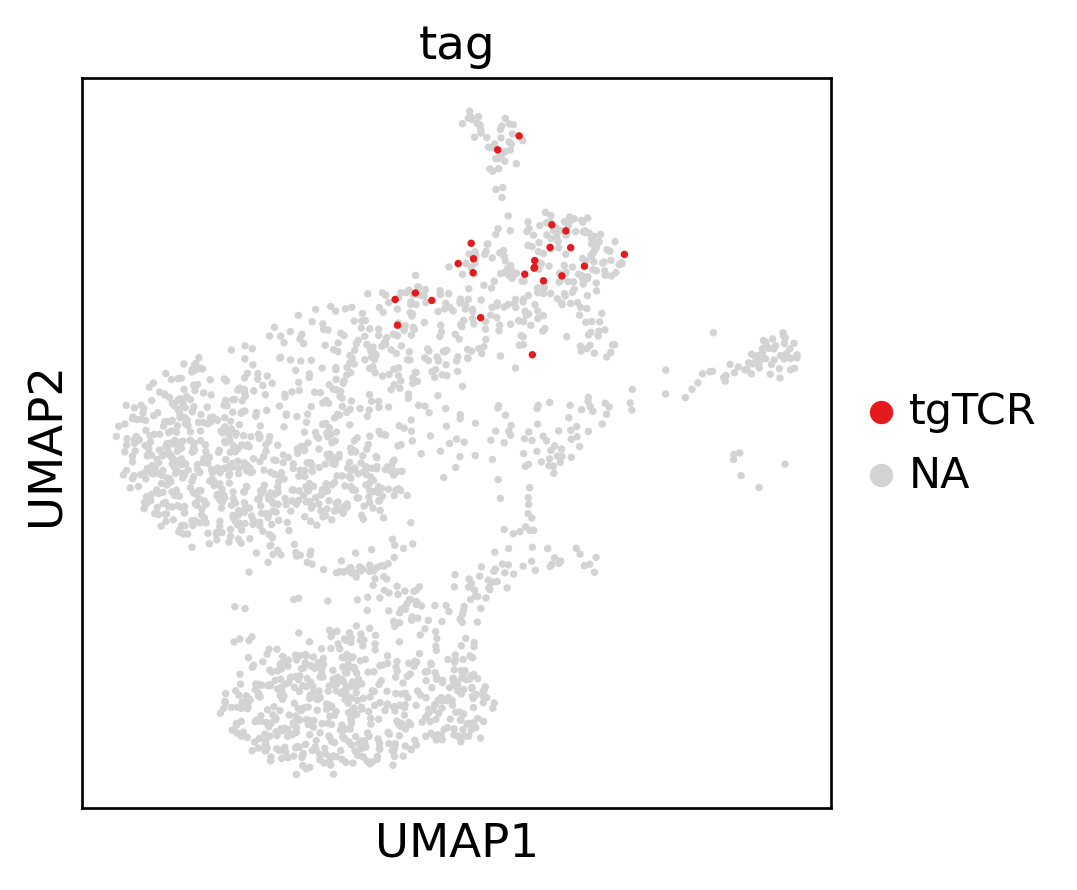

In [32]:
sc.pl.umap(adata, color=["tag"], size=[20],palette='Set1')

In [33]:
# Inspect other clones
adata.obs.loc[adata.obs["clone_id"] == "17", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells
0,CVVGDRGSALGRLHF,None,CTCSAAGTANERLFF,None,TRA+TRB,1
1,CVVGDRGSALGRLHF,None,CASGPGHLSNERLFF,None,TRA+TRB,1
2,CVVGDRGSALGRLHF,None,CASGVSGTGVYAEQFF,None,TRA+TRB,1
3,CVVGDRGSALGRLHF,None,CASGAGDQNTLYF,None,TRA+TRB,1
4,CVVGDRGSALGRLHF,None,CASGGLGGVDTQYF,None,TRA+TRB,1
5,CVVGDRGSALGRLHF,None,CASGDRAGGAYEQYF,None,TRA+TRB,1
6,CVVGDRGSALGRLHF,None,CASSDELGGRGTQYF,None,TRA+TRB,1
7,CVVGDRGSALGRLHF,None,CASSSEGTEVFF,None,TRA+TRB,1
8,CVVGDRGSALGRLHF,None,CASRGDWGGYEQYF,None,TRA+TRB,1
9,CALSASGGNYKPTF,CVVGDRGSALGRLHF,CASGDGTGAYEQYF,None,TRA+TRB,1


In [34]:
adata.obs.loc[adata.obs["clone_id"] == "140", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells
0,CVVGDRGSALGRLHF,None,CTCSAEQAEVFF,None,TRA+TRB,1
1,CVVGDRGSALGRLHF,None,CAWSHFPGTGAYAEQFF,CTCSADGTISNERLFF,TRA+TRB,1
2,CVVGDRGSALGRLHF,None,CTCSADSTGDNQAPLF,None,TRA+TRB,1
3,CVVGDRGSALGRLHF,None,CASGDAGGGSAETLYF,None,TRA+TRB,1
4,CVVGDRGSALGRLHF,None,CASRGQGITEVFF,None,TRA+TRB,1
5,CVVGDRGSALGRLHF,None,CASGDTTGDSGNTLYF,None,TRA+TRB,1
6,CVVGDRGSALGRLHF,None,CTCSAEGGAISDYTF,CASAPDWGGQDTQYF,TRA+TRB,1


<AxesSubplot:>

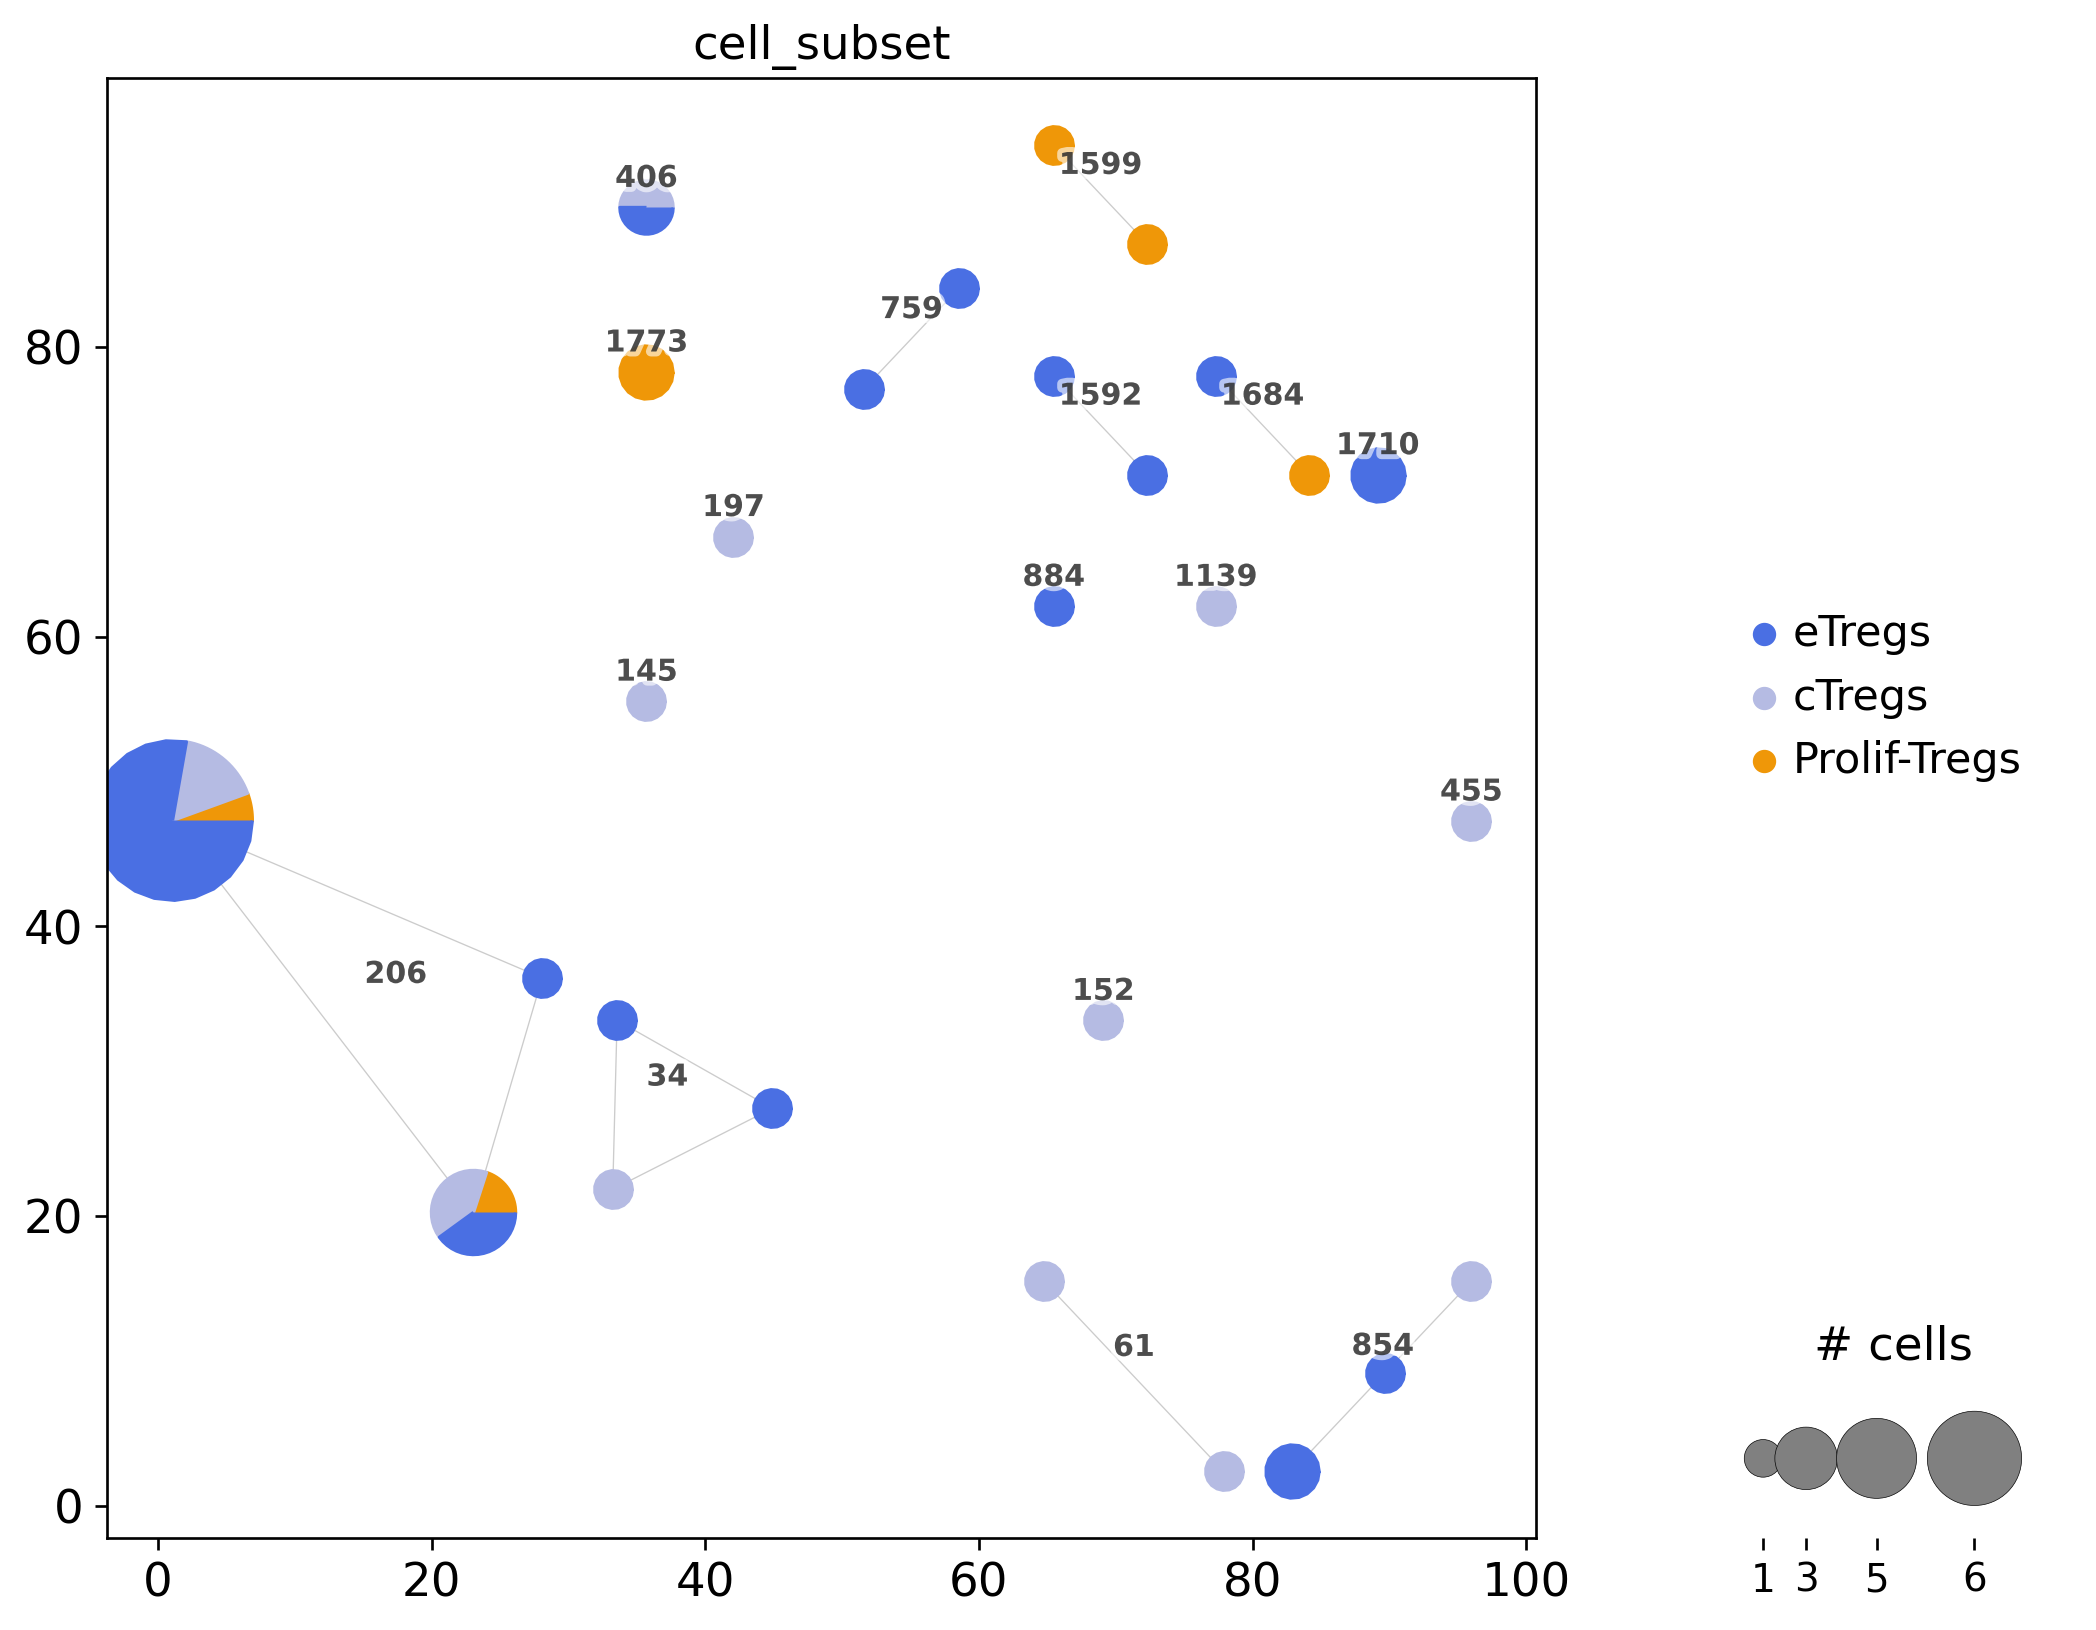

In [35]:
# Plot only Treg clones
ir.tl.clonotype_network(adata[adata.obs['cell_subset'].isin(["cTregs", 'eTregs', 'Prolif-Tregs'])], min_cells=2)
ir.pl.clonotype_network(adata[adata.obs['cell_subset'].isin(["cTregs", 'eTregs', 'Prolif-Tregs'])],
                        color="cell_subset", label_fontsize=9, panel_size=(8,8))

In [36]:
adata.obs.loc[adata.obs["clone_id"] == "34", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,n_cells
0,CALRRNNYAQGLTF,None,CSSRGTGNERLFF,None,TRA+TRB,1
1,CALRRNNYAQGLTF,None,CSSRETGNERLFF,None,TRA+TRB,1
2,CALRRNNYAQGLTF,None,None,None,TRA+TRB,1


In [37]:
adata.obs.loc[adata.obs['IR_VDJ_1_junction_aa'] == "CASSITTSAETLYF", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
        'clone_id'
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,clone_id,n_cells
0,None,None,CASSITTSAETLYF,None,TRA+TRB,206,5
1,CAVSSSTNAYKVIF,None,CASSITTSAETLYF,None,TRA+TRB,206,18
2,CAVSSSTNAYKVIF,CILRVDPGGNNKLTF,CASSITTSAETLYF,None,TRA+TRB,206,1


# Clonotype Analysis

### Clonal expansion

In [38]:
ir.tl.clonal_expansion(adata)

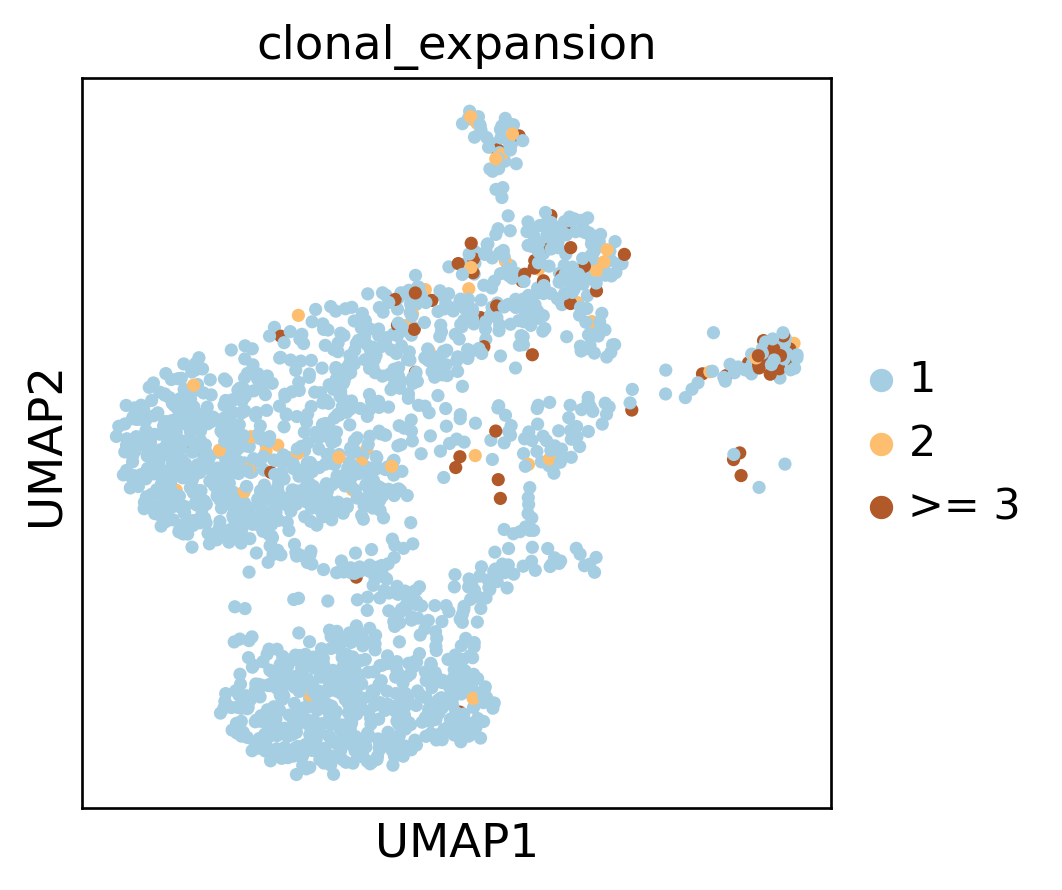

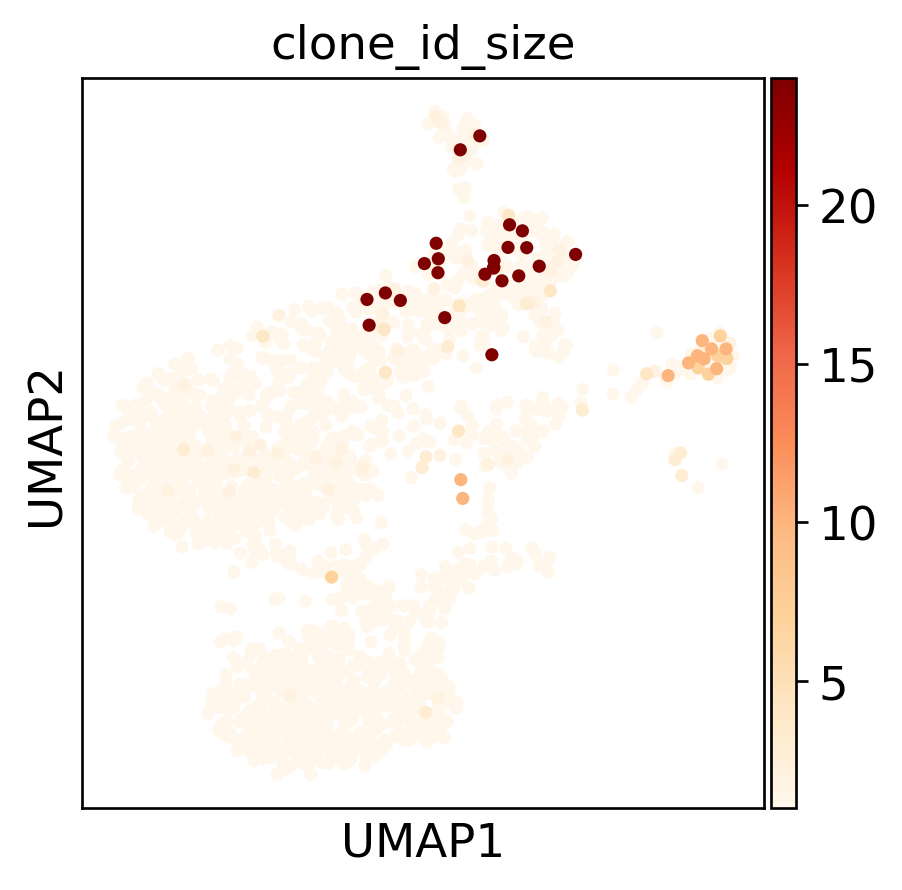

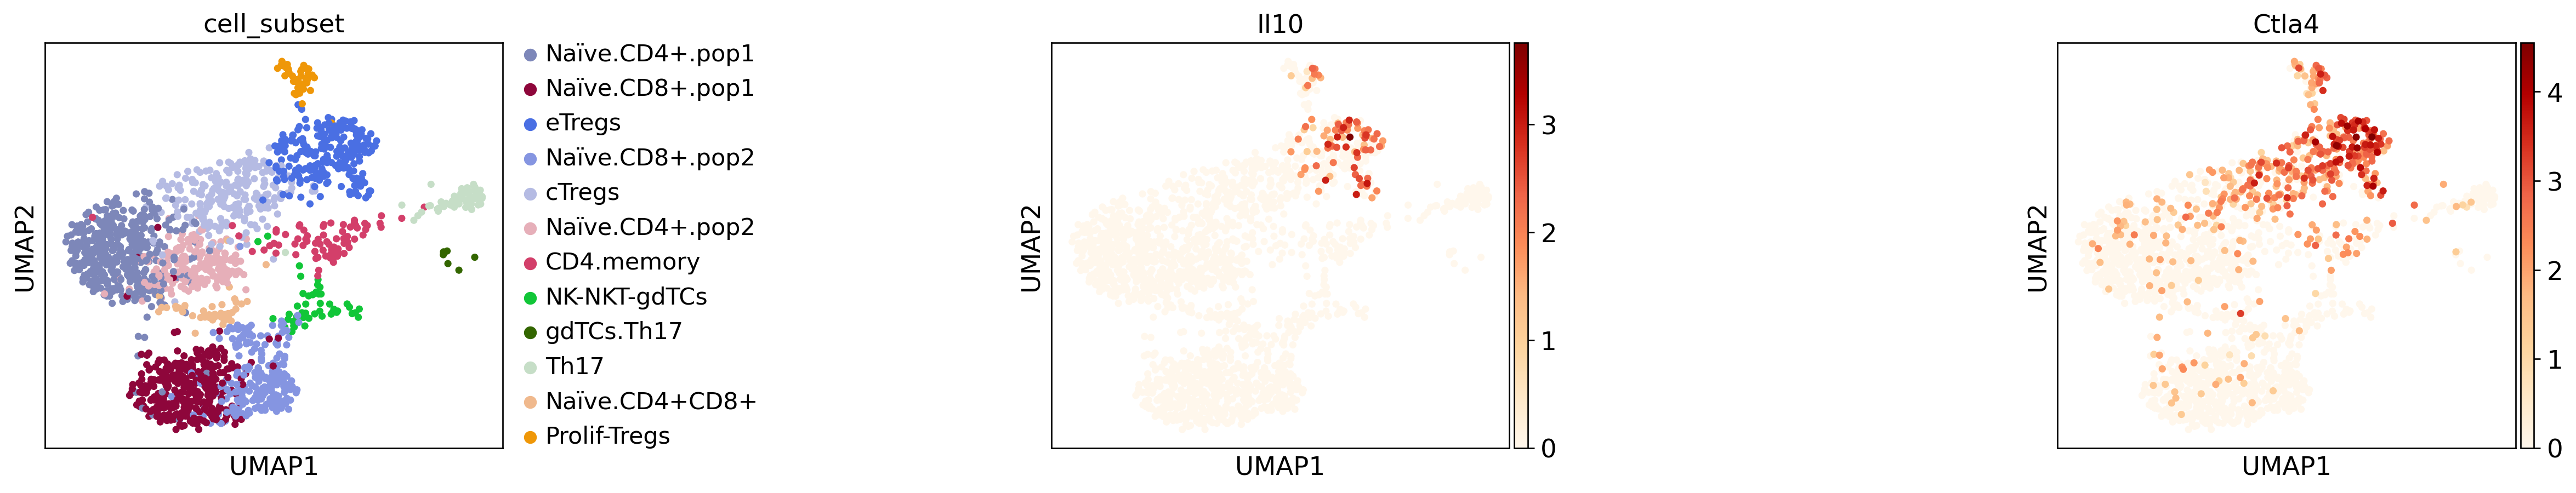

In [39]:
sc.pl.umap(adata, color=["clonal_expansion"],palette='Paired')
sc.pl.umap(adata, color=["clone_id_size"] )#color_map='PuBu'
sc.pl.umap(adata, color=["cell_subset","Il10","Ctla4"], wspace=1)

### Figure 2h:

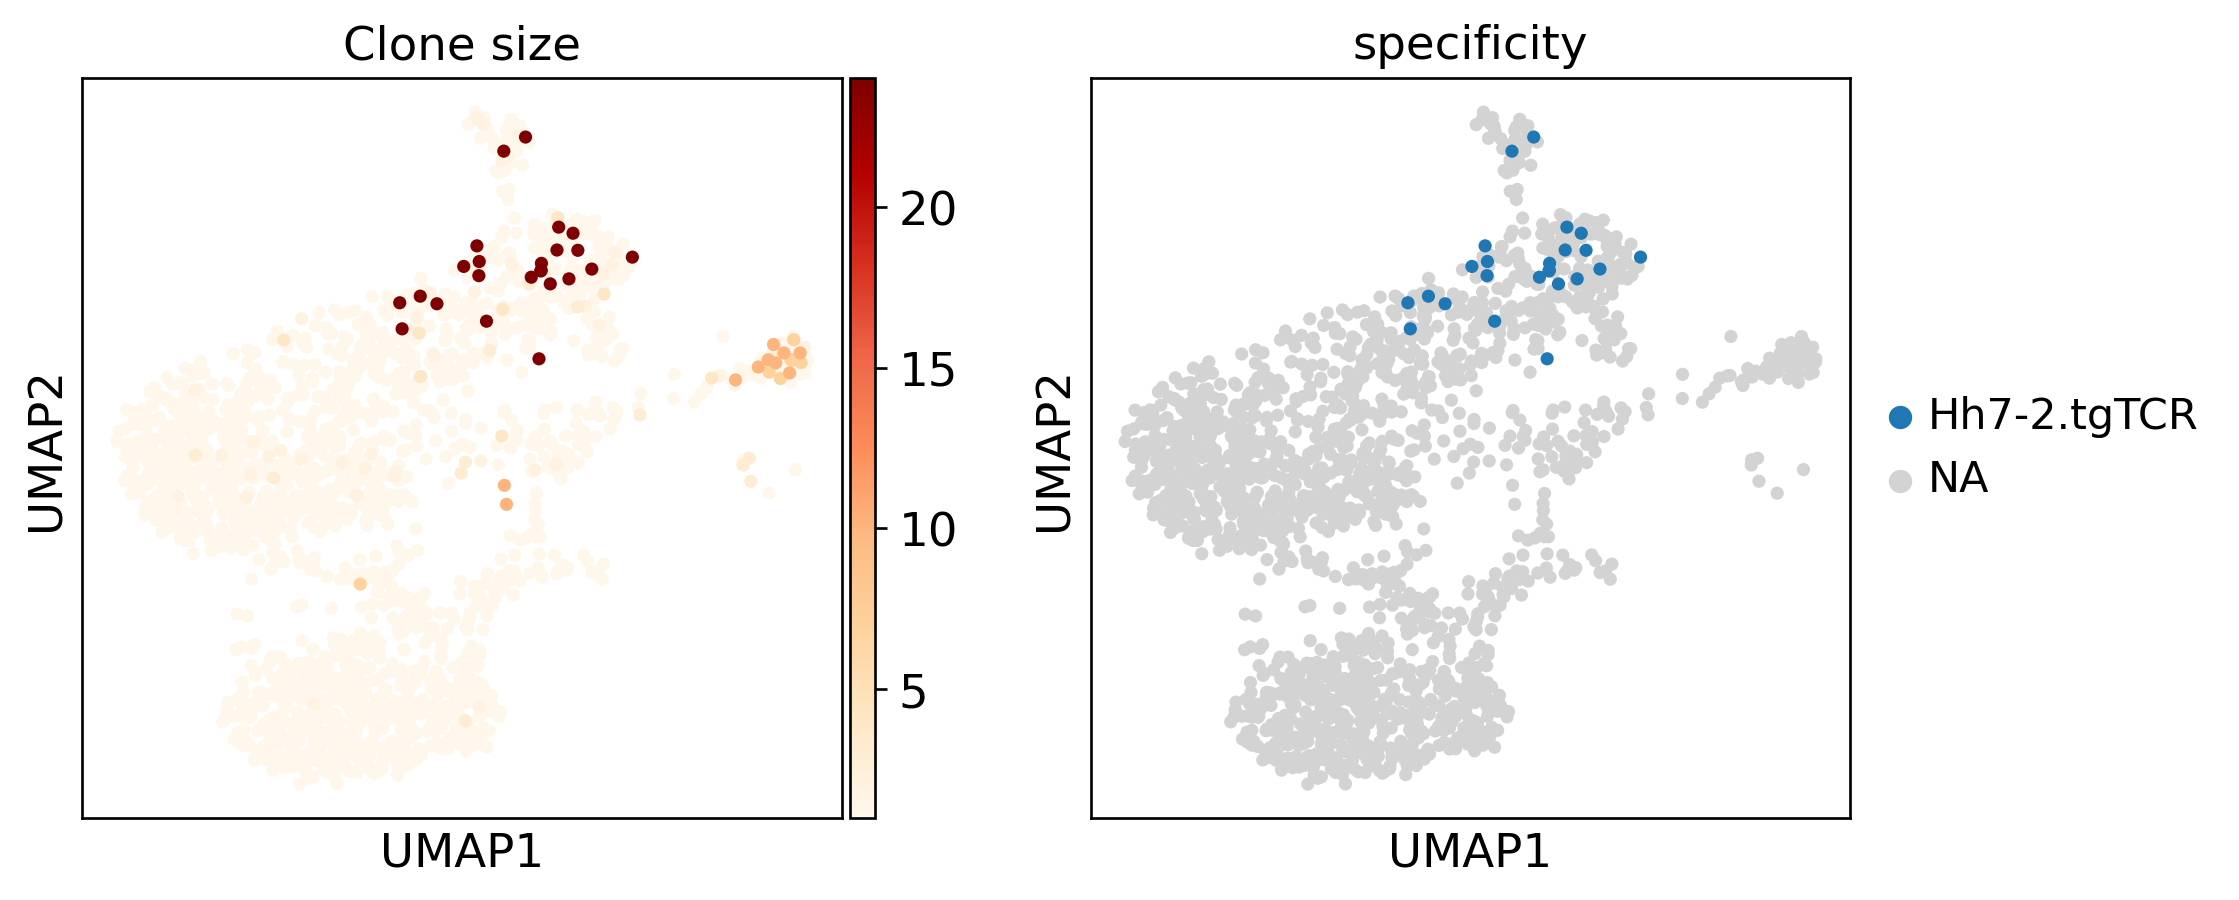

In [40]:
sc.pl.umap(adata, color=["clone_id_size", "specificity"], title="Clone size")#color_map='PuBu'

clonal_expansion refers to expansion categories, i.e singleton clonotypes, clonotypes with 2 cells and more than 2 cells. The clonotype_size refers to the absolute number of cells in a clonotype.

In [41]:
freq, stat = ir.tl.clonotype_imbalance(
    adata,
    replicate_col="location",
    groupby='cell_subset',
    case_label="eTregs",
    control_label="cTregs",
    inplace=False,
)
top_differential_clonotypes = stat["clone_id"].tolist()[:5]

In [42]:
top_differential_clonotypes

['206', '1684', '1716', '1773', '1710']

In [43]:
freq, stat = ir.tl.clonotype_imbalance(
    adata,
    replicate_col="location",
    groupby='cell_subset',
    case_label="eTregs",
    control_label="Th17",
    inplace=False,
)
top_differential_clonotypes = stat["clone_id"].tolist()[:5]

In [44]:
top_differential_clonotypes

['206', '17', '140', '61', '854']

<AxesSubplot:>

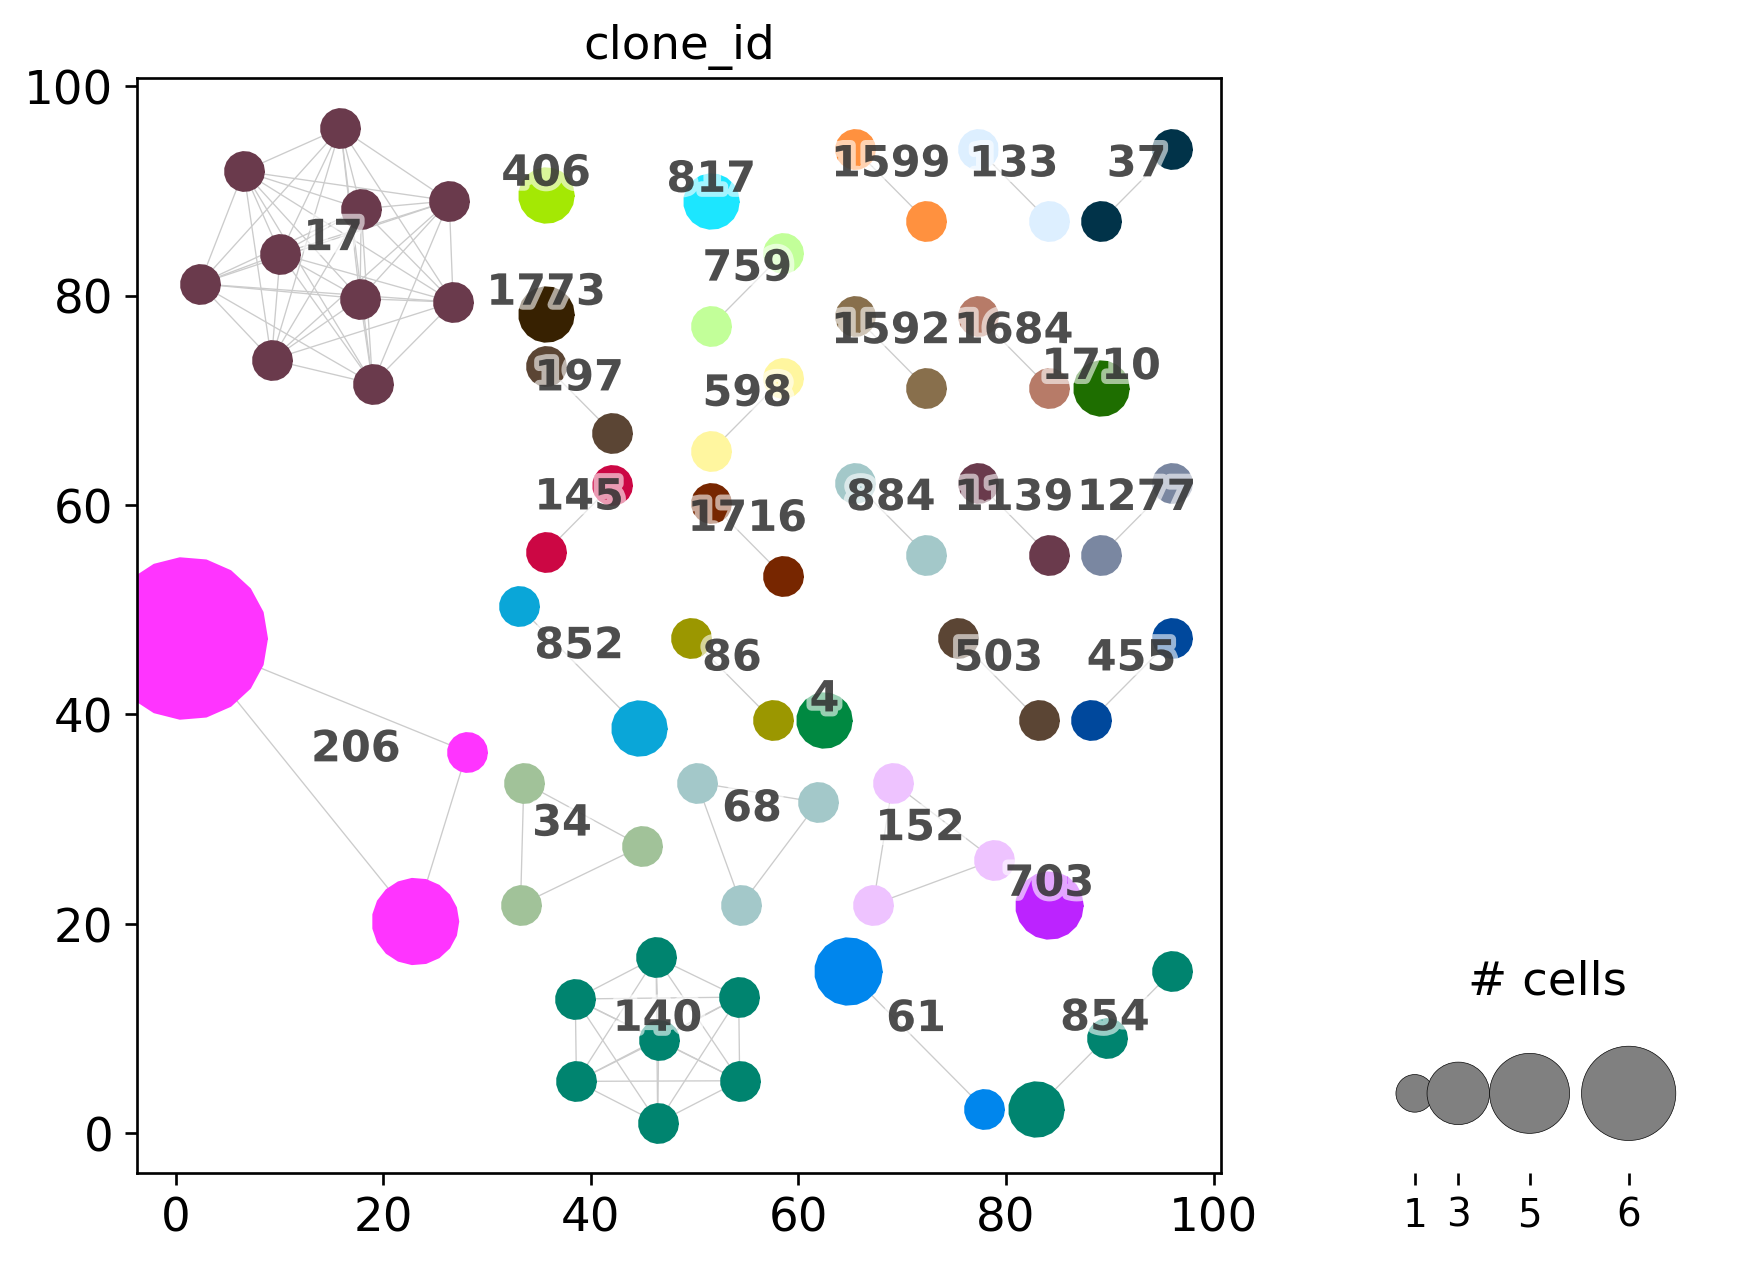

In [45]:
ir.pl.clonotype_network(
    adata,
    color="clone_id",
    panel_size=(6, 6),
)

<AxesSubplot:>

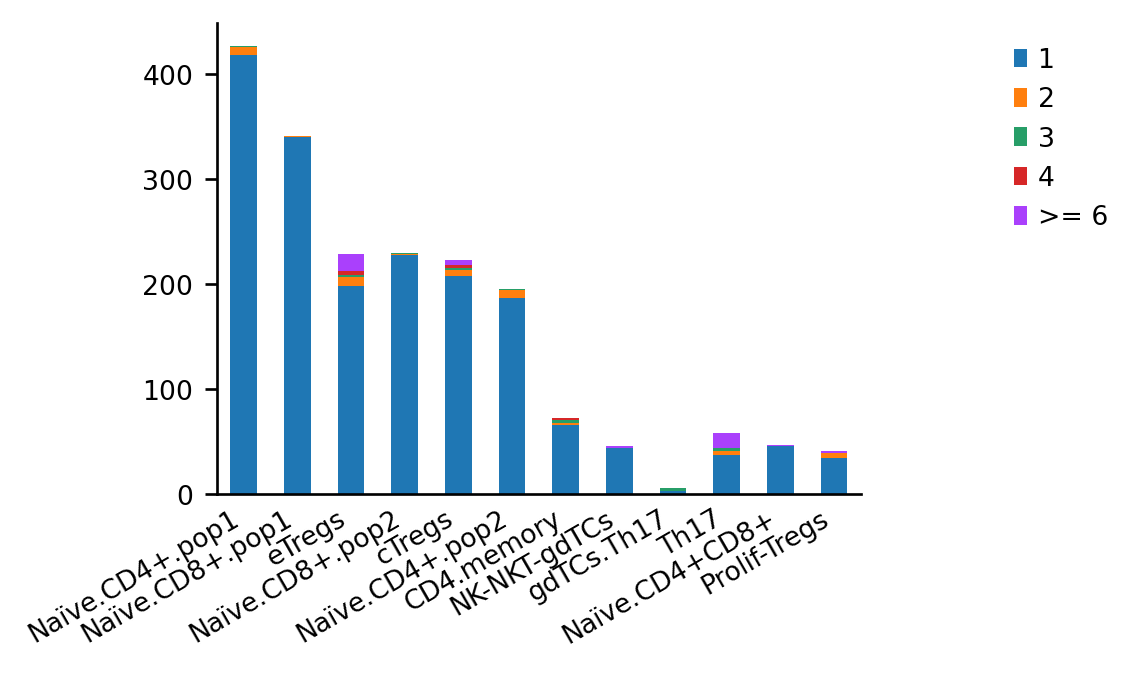

In [46]:
ir.pl.clonal_expansion(adata, groupby="cell_subset", clip_at=6, normalize=False)

<AxesSubplot:>

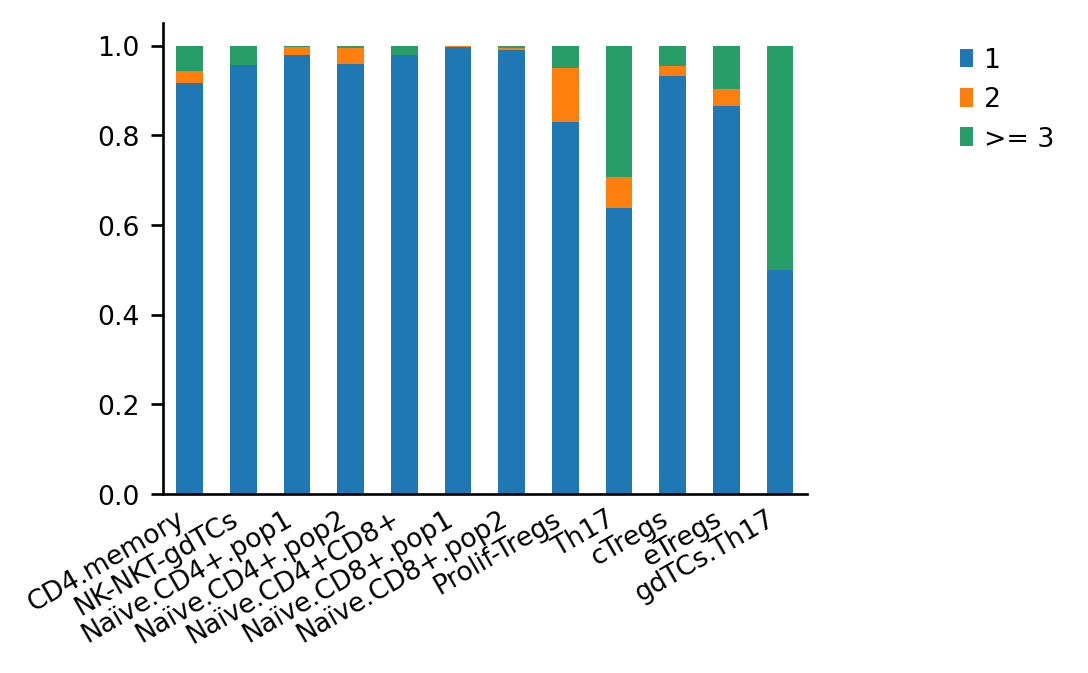

In [47]:
ir.pl.clonal_expansion(adata, "cell_subset_int")

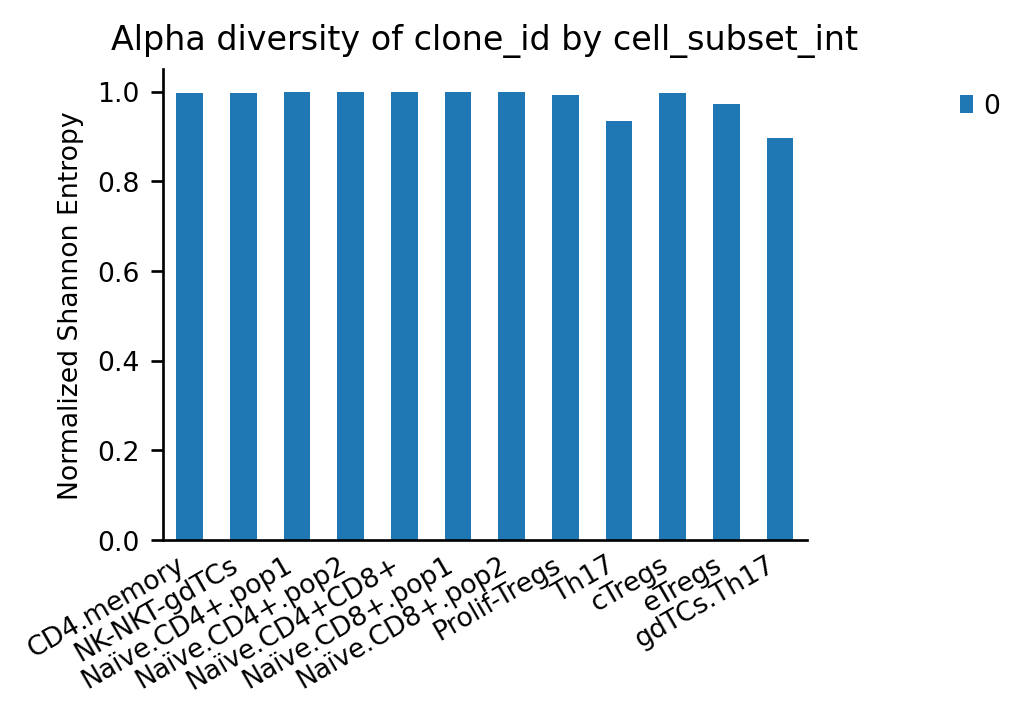

In [48]:
ax = ir.pl.alpha_diversity(adata, groupby="cell_subset_int",)

### Clonotype abundance: Figure 2i

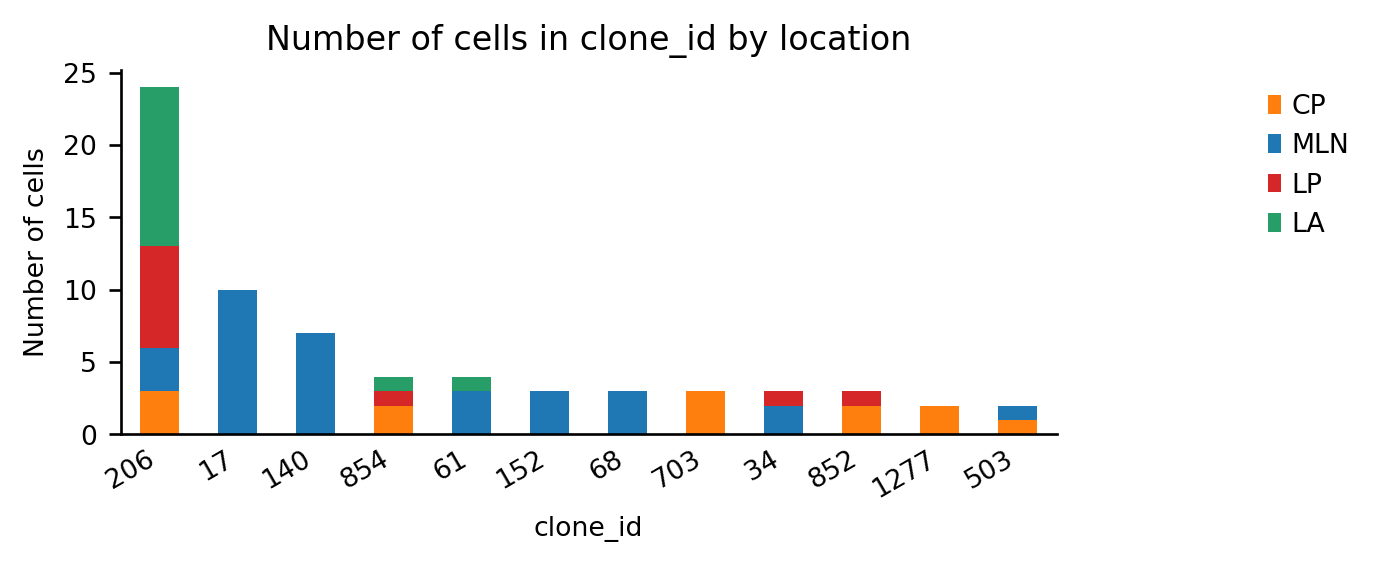

In [49]:
with plt.rc_context({'figure.figsize': (5, 2)}):
    ax = ir.pl.group_abundance(
        adata, groupby="clone_id", target_col="location", max_cols=12, fig_kws={"dpi": 120}
    )
#plt.savefig('/nfs/team205/rb29/mice_gutTCRtg_project/Src/Mice-gut.TCRtg/new_analysis/figures/Bar_TCRclonotypes_location_tgTCR_vs2.pdf', format='pdf')

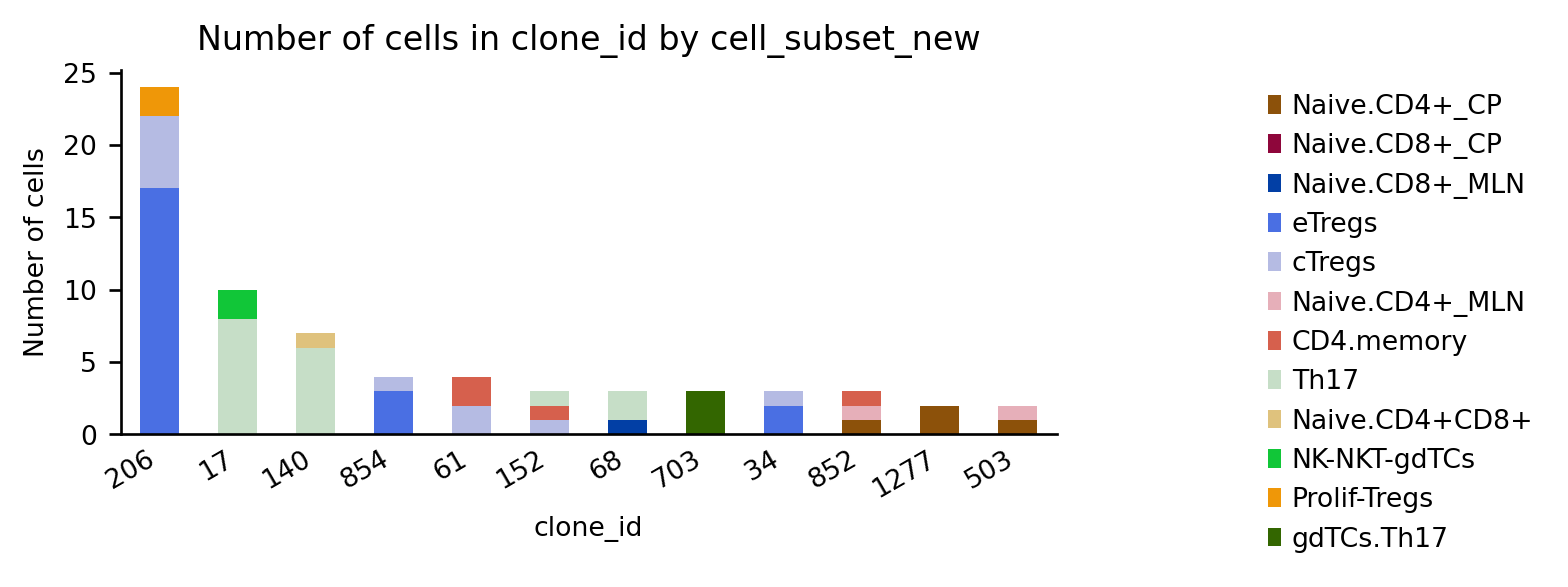

In [50]:
with plt.rc_context({'figure.figsize': (5, 2)}):
    ax = ir.pl.group_abundance(adata, groupby="clone_id", target_col="cell_subset_new",title='#Cells in clonotype by T cell subset', max_cols=12, fig_kws={"dpi": 120})
#plt.savefig('/nfs/team205/rb29/mice_gutTCRtg_project/Src/Mice-gut.TCRtg/new_analysis/figures/Bar_TCRclonotypes_celltypes_tgTCR_vs2.pdf', format='pdf')

In [51]:
adata.obs["tag"].value_counts()

tgTCR    24
Name: tag, dtype: int64

In [52]:
top12clones= adata.obs.loc[adata.obs["clone_id"].isin(['206','17','140','854','61','152','68','703','34','852','1277','503'])].groupby(
    [   "clone_id",
        'IR_VJ_1_v_call',
         'IR_VJ_1_j_call',
        "IR_VJ_1_junction_aa",
        "IR_VJ_2_junction_aa",
        'IR_VDJ_1_v_call',
         'IR_VDJ_1_j_call',
        "IR_VDJ_1_junction_aa",
        "IR_VDJ_2_junction_aa",
        "receptor_subtype",
         'cell_subset_new',
         'location'
    ],
    observed=True,
).size().reset_index(name="n_cells")

In [53]:
top12clones

,clone_id,IR_VJ_1_v_call,IR_VJ_1_j_call,IR_VJ_1_junction_aa,IR_VJ_2_junction_aa,IR_VDJ_1_v_call,IR_VDJ_1_j_call,IR_VDJ_1_junction_aa,IR_VDJ_2_junction_aa,receptor_subtype,cell_subset_new,location,n_cells
0,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV1,TRBJ1-4,CTCSAAGTANERLFF,None,TRA+TRB,Th17,MLN,1
1,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV13-2,TRBJ1-4,CASGPGHLSNERLFF,None,TRA+TRB,Th17,MLN,1
2,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV12-2+TRBV13-2,TRBJ2-1,CASGVSGTGVYAEQFF,None,TRA+TRB,Th17,MLN,1
3,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV12-2+TRBV13-2,TRBJ2-4,CASGAGDQNTLYF,None,TRA+TRB,Th17,MLN,1
4,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV12-2+TRBV13-2,TRBJ2-5,CASGGLGGVDTQYF,None,TRA+TRB,Th17,MLN,1
5,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV12-2+TRBV13-2,TRBJ2-7,CASGDRAGGAYEQYF,None,TRA+TRB,Th17,MLN,1
6,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV13-1,TRBJ2-5,CASSDELGGRGTQYF,None,TRA+TRB,NK-NKT-gdTCs,MLN,1
7,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV13-1,TRBJ2-7,CASRGDWGGYEQYF,None,TRA+TRB,Th17,MLN,1
8,17,TRAV11,TRAJ18,CVVGDRGSALGRLHF,None,TRBV29,TRBJ1-1,CASSSEGTEVFF,None,TRA+TRB,NK-NKT-gdTCs,MLN,1
9,17,TRAV6N-6,TRAJ6,CALSASGGNYKPTF,CVVGDRGSALGRLHF,TRBV12-2+TRBV13-2,TRBJ2-7,CASGDGTGAYEQYF,None,TRA+TRB,Th17,MLN,1


In [54]:
top12clones.to_csv("Top12clones_Fig2I.csv")

In [55]:
adata.write(path+'/h5ad_files/TCs_only_TCRanalysis.h5ad')

---